# Visualize the Optimization Process

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from torch.autograd import Variable
from sklearn.decomposition import PCA
import pandas as pd
import copy
from sklearn.preprocessing import StandardScaler, Normalizer
import matplotlib
from matplotlib.pyplot import figure
torch.manual_seed(1)

In [27]:
train_data = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)

test_data = torchvision.datasets.MNIST(root='./data', train=False,transform=transforms.ToTensor())

def get_train_loader(batch_size):
    return torch.utils.data.DataLoader(dataset=train_data,batch_size=batch_size,shuffle=True)

def get_test_loader(batch_size):
    return torch.utils.data.DataLoader(dataset=test_data,batch_size=batch_size,shuffle=False)

In [28]:
class SimpleDNN(nn.Module):
    def __init__(self):
        super(SimpleDNN, self).__init__()
        self.input_layer = nn.Linear(784, 512)
        self.hidden_layer = nn.Linear(512, 100)
        self.output_layer = nn.Linear(100, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.input_layer(x))
        x = F.relu(self.hidden_layer(x))
        return self.output_layer(x)

In [29]:
def train_model(model, num_epochs, batch_size, log_interval):
    model.train()
    print('Training started...')
    train_data_loader = get_train_loader(batch_size)
    total_steps = len(train_data_loader)
    loss_tracker, accuracy_tracker, epoch_log = [], [], []
    model_weights_df = pd.DataFrame()

    for epoch in range(num_epochs):
        total_loss, total_accuracy, epoch_data = 0, 0, pd.DataFrame()

        for i, (inputs, targets) in enumerate(train_data_loader):
            inputs, targets = Variable(inputs), Variable(targets)
            optimizer.zero_grad()

            predictions = model(inputs)
            loss = loss_func(predictions, targets)
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

            _, predicted_labels = torch.max(predictions, 1)
            total_accuracy += (predicted_labels == targets).sum().item()

            if (i + 1) % log_interval == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{total_steps}], Loss: {loss.item():.5f}')

        loss_tracker.append(total_loss / total_steps)
        accuracy_tracker.append(100.0 * total_accuracy / len(train_data_loader.dataset))

        for name, param in model.named_parameters():
            if 'weight' in name:
                epoch_data = pd.concat([epoch_data, pd.DataFrame(param.detach().numpy().flatten()).T], axis=1)

        model_weights_df = pd.concat([model_weights_df, epoch_data], axis=0)

    return epoch_log, loss_tracker, accuracy_tracker, model_weights_df

In [30]:
def evaluate_model(model, loss_func, batch_size):
    test_data_loader = get_test_loader(batch_size)
    model.eval()
    with torch.no_grad():
        total_samples, total_correct, total_loss = 0, 0, 0

        for inputs, targets in test_data_loader:
            inputs, targets = Variable(inputs), Variable(targets)

            outputs = model(inputs)
            total_loss += loss_func(outputs, targets).item()

            _, predicted_labels = torch.max(outputs, 1)
            total_correct += (predicted_labels == targets).sum().item()

        accuracy = 100.0 * total_correct / len(test_data_loader.dataset)
        loss = total_loss / len(test_data_loader)
        print(f'Test Accuracy: {accuracy}%, Test Loss: {loss:.4f}')
        return accuracy, loss

In [31]:
param_counts = []
model_instance = SimpleDNN()

for param in model_instance.parameters():
    param_counts.append(param.numel())

print(f'Total number of parameters: {np.sum(param_counts)}')

Total number of parameters: 454230


In [38]:
epochs = 50
all_weights_df = pd.DataFrame()
train_accuracy_log, test_accuracy_log = {}, {}
train_loss_log={}
test_loss_log = {}
train_batch_size, test_batch_size = 1000, 1000
interval_log = 60
criterion = nn.NLLLoss() 

for run in range(8):
    model_clone = SimpleDNN()  
    print(f"Executing run {run}")
    optimizer = torch.optim.SGD(model_clone.parameters(), lr=0.0006, momentum=0.9, weight_decay=5e-4) 

    epochs_trained, losses_recorded, accuracy_recorded, weights_collected = train_model(
        model_clone, epochs, train_batch_size, interval_log
    )
    test_accuracy, test_loss_value = evaluate_model(model_clone, criterion, test_batch_size)

    all_weights_df = pd.concat([all_weights_df, weights_collected], ignore_index=True)

    train_accuracy_log[run] = accuracy_recorded
    test_accuracy_log[run] = test_accuracy
    train_loss_log[run] = losses_recorded
    test_loss_log[run] = test_loss_value

Executing run 0
Training started...
Epoch [1/50], Step [60/60], Loss: 2.29422
Epoch [2/50], Step [60/60], Loss: 2.27712
Epoch [3/50], Step [60/60], Loss: 2.26403
Epoch [4/50], Step [60/60], Loss: 2.23950
Epoch [5/50], Step [60/60], Loss: 2.21842
Epoch [6/50], Step [60/60], Loss: 2.19171
Epoch [7/50], Step [60/60], Loss: 2.16010
Epoch [8/50], Step [60/60], Loss: 2.12002
Epoch [9/50], Step [60/60], Loss: 2.07694
Epoch [10/50], Step [60/60], Loss: 2.01020
Epoch [11/50], Step [60/60], Loss: 1.94774
Epoch [12/50], Step [60/60], Loss: 1.85567
Epoch [13/50], Step [60/60], Loss: 1.76053
Epoch [14/50], Step [60/60], Loss: 1.66065
Epoch [15/50], Step [60/60], Loss: 1.52783
Epoch [16/50], Step [60/60], Loss: 1.44970
Epoch [17/50], Step [60/60], Loss: 1.31205
Epoch [18/50], Step [60/60], Loss: 1.18590
Epoch [19/50], Step [60/60], Loss: 1.10693
Epoch [20/50], Step [60/60], Loss: 1.05382
Epoch [21/50], Step [60/60], Loss: 0.98138
Epoch [22/50], Step [60/60], Loss: 0.90509
Epoch [23/50], Step [60/60]

Epoch [37/50], Step [60/60], Loss: 0.54751
Epoch [38/50], Step [60/60], Loss: 0.54275
Epoch [39/50], Step [60/60], Loss: 0.50301
Epoch [40/50], Step [60/60], Loss: 0.48794
Epoch [41/50], Step [60/60], Loss: 0.52630
Epoch [42/50], Step [60/60], Loss: 0.49651
Epoch [43/50], Step [60/60], Loss: 0.46854
Epoch [44/50], Step [60/60], Loss: 0.47048
Epoch [45/50], Step [60/60], Loss: 0.46498
Epoch [46/50], Step [60/60], Loss: 0.44901
Epoch [47/50], Step [60/60], Loss: 0.41908
Epoch [48/50], Step [60/60], Loss: 0.40536
Epoch [49/50], Step [60/60], Loss: 0.46787
Epoch [50/50], Step [60/60], Loss: 0.40245
Test Accuracy: 88.06%, Test Loss: -5.9299
Executing run 4
Training started...
Epoch [1/50], Step [60/60], Loss: 2.29417
Epoch [2/50], Step [60/60], Loss: 2.28261
Epoch [3/50], Step [60/60], Loss: 2.27142
Epoch [4/50], Step [60/60], Loss: 2.25799
Epoch [5/50], Step [60/60], Loss: 2.23796
Epoch [6/50], Step [60/60], Loss: 2.21303
Epoch [7/50], Step [60/60], Loss: 2.19013
Epoch [8/50], Step [60/60]

Epoch [22/50], Step [60/60], Loss: 0.94755
Epoch [23/50], Step [60/60], Loss: 0.90280
Epoch [24/50], Step [60/60], Loss: 0.84168
Epoch [25/50], Step [60/60], Loss: 0.79348
Epoch [26/50], Step [60/60], Loss: 0.76093
Epoch [27/50], Step [60/60], Loss: 0.77077
Epoch [28/50], Step [60/60], Loss: 0.67058
Epoch [29/50], Step [60/60], Loss: 0.67107
Epoch [30/50], Step [60/60], Loss: 0.64464
Epoch [31/50], Step [60/60], Loss: 0.63288
Epoch [32/50], Step [60/60], Loss: 0.60564
Epoch [33/50], Step [60/60], Loss: 0.56972
Epoch [34/50], Step [60/60], Loss: 0.57410
Epoch [35/50], Step [60/60], Loss: 0.54549
Epoch [36/50], Step [60/60], Loss: 0.56671
Epoch [37/50], Step [60/60], Loss: 0.49748
Epoch [38/50], Step [60/60], Loss: 0.52523
Epoch [39/50], Step [60/60], Loss: 0.49475
Epoch [40/50], Step [60/60], Loss: 0.48766
Epoch [41/50], Step [60/60], Loss: 0.49267
Epoch [42/50], Step [60/60], Loss: 0.48176
Epoch [43/50], Step [60/60], Loss: 0.46200
Epoch [44/50], Step [60/60], Loss: 0.44576
Epoch [45/5

In [16]:
train_acc_list = [train_acc_tracker[key] for key in train_acc_tracker]
train_loss_list = [train_loss_tracker[key] for key in train_loss_tracker]

print(full_data_df)

train_acc_df = pd.DataFrame(train_acc_list)
train_loss_df = pd.DataFrame(train_loss_list)

flattened_train_acc = np.array(train_acc_df).flatten()
flattened_train_loss = np.array(train_loss_df).flatten()

print(f'Shape of Loss: {flattened_train_loss.shape}, Shape of Accuracy: {flattened_train_acc.shape}')

full_weights_df = pd.DataFrame(full_data_df)
print(full_weights_df)

              0             1             2             3             4    \
0    4.140669e-03 -5.881035e-03 -4.887505e-03  7.859903e-03  3.515291e-04   
1   -3.314531e-05 -2.108467e-04 -5.017881e-05  6.904317e-04  7.558599e-06   
2   -7.994406e-07  1.341210e-05  6.303232e-06 -1.209037e-05 -2.324914e-06   
3   -4.374175e-08 -5.723554e-07 -2.562092e-07 -2.170352e-07 -2.493152e-09   
4    1.001619e-08  2.422941e-08  3.698626e-09  1.961372e-08  3.318906e-09   
..            ...           ...           ...           ...           ...   
395  4.154089e-39 -1.641439e-38  4.135840e-39  4.239757e-38  5.728884e-39   
396  4.154089e-39 -1.641439e-38  4.135840e-39 -4.977940e-38  5.728884e-39   
397  4.154089e-39 -1.641439e-38  4.135840e-39  4.333245e-38  5.728884e-39   
398  4.154089e-39 -1.641439e-38  4.135840e-39 -5.081648e-38  5.728884e-39   
399  4.154089e-39 -1.641439e-38  4.135840e-39  4.420902e-38  5.728884e-39   

              5             6             7             8             9    

In [39]:
def perform_pca(weight_df, iteration):
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(weight_df)

    iteration_col = np.full((pca_transformed.shape[0], 1), iteration)
    pca_dataframe = pd.DataFrame(np.append(pca_transformed, iteration_col, axis=1), columns=['Dim1', 'Dim2', 'Iteration'])
    return pca_dataframe

In [40]:
full_weights_array = np.array(full_weights_df)
pca_processor = PCA(n_components=2)
pca_result = pca_processor.fit_transform(full_weights_array)

all_epochs_df = pd.DataFrame(pca_result, columns=['Dim1', 'Dim2'])

epoch_sequence = [i for i in range(epochs)] * 8
iteration_sequence = np.repeat([i for i in range(8)], epochs)

all_epochs_df['Epoch'] = epoch_sequence
all_epochs_df['Iteration'] = iteration_sequence
all_epochs_df['Accuracy'] = flattened_train_acc
all_epochs_df['Loss'] = flattened_train_loss

filtered_epochs_df = all_epochs_df.loc[(all_epochs_df['Epoch'] + 1) % 3 == 0].reset_index(drop=True)
print(filtered_epochs_df)

          Dim1      Dim2  Epoch  Iteration   Accuracy      Loss
0     8.130220 -4.178397      2          0  92.258333  0.274900
1    10.050727 -5.129209      5          0  95.083333  0.173020
2    11.314235 -5.733309      8          0  96.598333  0.121166
3    12.179072 -6.142483     11          0  97.421667  0.092927
4    12.802426 -6.432230     14          0  97.941667  0.072527
..         ...       ...    ...        ...        ...       ...
123  -7.601894 -5.832695     35          7  99.666667  0.018366
124  -7.573802 -5.812872     38          7  99.761667  0.015731
125  -7.531285 -5.785737     41          7  99.833333  0.013253
126  -7.471238 -5.743764     44          7  99.875000  0.011409
127  -7.401623 -5.694645     47          7  99.896667  0.010205

[128 rows x 6 columns]


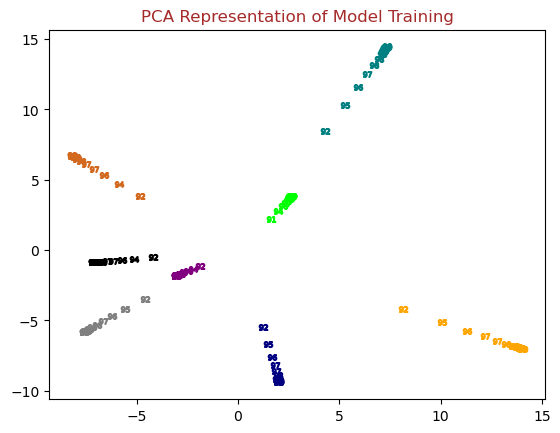

<Figure size 3600x1800 with 0 Axes>

In [42]:
color_map = ['orange', 'teal', 'purple', 'navy', 'lime', 'chocolate', 'black', 'grey']

for idx in range(len(marker_values)):
    marker = marker_values[idx]
    color_idx = filtered_epochs_df['Iteration'][idx]
    plt.scatter(filtered_epochs_df['Dim1'][idx], filtered_epochs_df['Dim2'][idx], marker=f'${marker}$', color=color_map[color_idx])
    plt.title("PCA Representation of Model Training", color="brown")

plt.figure(figsize=[12,6], dpi=300)

plt.show()

           PC1       PC2  Epoch  Iteration   Accuracy      Loss
0    28.692455  6.458359      0          0  72.481667  1.208927
1    24.512159  7.544705      1          0  90.098333  0.354300
2    23.137307  8.296314      2          0  92.258333  0.274900
3    21.940183  8.954083      3          0  93.438333  0.229962
4    20.772988  9.527093      4          0  94.453333  0.197784
..         ...       ...    ...        ...        ...       ...
395 -20.535291 -8.709143     45          7  99.908333  0.010575
396 -21.514508 -8.685691     46          7  99.885000  0.010595
397 -22.500072 -8.662560     47          7  99.896667  0.010205
398 -23.485635 -8.637995     48          7  99.908333  0.009528
399 -24.473926 -8.607748     49          7  99.935000  0.008780

[400 rows x 6 columns]


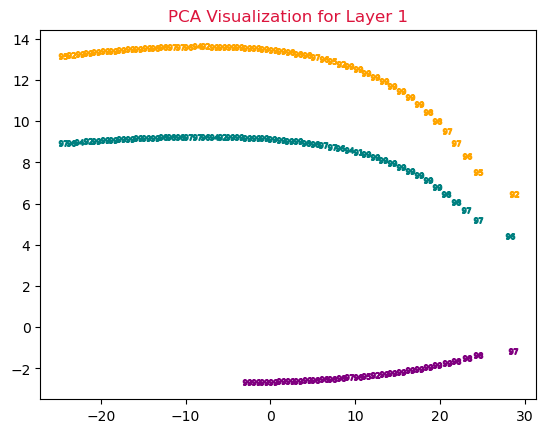

In [54]:
layer1_df = all_epochs_df.iloc[:,:7840]
transformed_layer1 = np.array(layer1_df)
pca_layer1 = PCA(n_components=2)
layer1_transformed_data = pca_layer1.fit_transform(transformed_layer1)

layer1_pca_df = pd.DataFrame(layer1_transformed_data, columns=['PC1', 'PC2'])

epoch_vals_layer1 = [i for i in range(50)] * 8 
iteration_vals_layer1 = np.repeat([i for i in range(8)], 50)

layer1_pca_df['Epoch'] = epoch_vals_layer1
layer1_pca_df['Iteration'] = iteration_vals_layer1
layer1_pca_df["Accuracy"] = flattened_train_acc
layer1_pca_df["Loss"] = flattened_train_loss

print(layer1_pca_df)

for idx in range(len(marker_values)):
    marker_val = marker_values[idx]
    color_idx = layer1_pca_df['Iteration'][idx]
    plt.scatter(layer1_pca_df['PC1'][idx], layer1_pca_df['PC2'][idx], marker=f'${marker_val}$', color=color_map[color_idx])
    plt.title("PCA Visualization for Layer 1", color="crimson")

plt.show()

# Observe Gradient Norm During Training

Input Data Shape: torch.Size([300, 1]) 
Output Data Shape: torch.Size([300, 1])
Total Parameters in NewModel: 901
Epoch 100: Loss = 0.0394, Grad Norm = 0.06919747032110714
Epoch 200: Loss = 0.0375, Grad Norm = 0.05465504813310095
Epoch 300: Loss = 0.0363, Grad Norm = 0.04459884109158249


/var/folders/8y/wy29tdf90198vqr7bxnzft640000gn/T/ipykernel_77299/2295657236.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_data, y_data = torch.tensor(x_data, dtype=torch.float32), torch.tensor(y_data, dtype=torch.float32)


Epoch 400: Loss = 0.0354, Grad Norm = 0.037420954561405345
Epoch 500: Loss = 0.0348, Grad Norm = 0.03242203691543405
Epoch 600: Loss = 0.0343, Grad Norm = 0.028997780343513573
Epoch 700: Loss = 0.0340, Grad Norm = 0.026722136037335618
Epoch 800: Loss = 0.0336, Grad Norm = 0.025225666551036283
Epoch 900: Loss = 0.0333, Grad Norm = 0.024204826173038537
Epoch 1000: Loss = 0.0330, Grad Norm = 0.023510362038909275
Epoch 1100: Loss = 0.0328, Grad Norm = 0.023010844577505553
Epoch 1200: Loss = 0.0325, Grad Norm = 0.02262108514756302
Epoch 1300: Loss = 0.0322, Grad Norm = 0.02230946431651885
Epoch 1400: Loss = 0.0320, Grad Norm = 0.022047615010520896
Epoch 1500: Loss = 0.0318, Grad Norm = 0.02181490085841201
Epoch 1600: Loss = 0.0315, Grad Norm = 0.021612140620522566
Epoch 1700: Loss = 0.0313, Grad Norm = 0.02142219066766823
Epoch 1800: Loss = 0.0311, Grad Norm = 0.021235453662292358
Epoch 1900: Loss = 0.0308, Grad Norm = 0.02103340840850563
Epoch 2000: Loss = 0.0306, Grad Norm = 0.02084590435

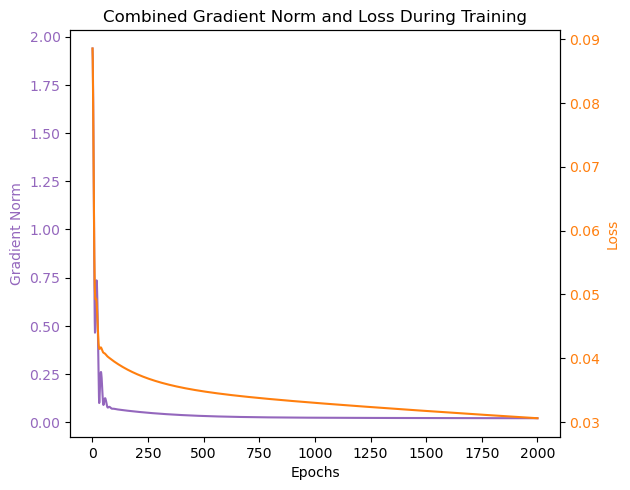

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable

torch.manual_seed(123)
x_data = torch.unsqueeze(torch.linspace(-1, 1, 300), dim=1)  
y_data = (np.sin(5*np.pi*x_data))/(5*np.pi*x_data) 

print('Input Data Shape:', x_data.shape,"\nOutput Data Shape:", y_data.shape)

x_data, y_data = torch.tensor(x_data, dtype=torch.float32), torch.tensor(y_data, dtype=torch.float32)
n_samples, n_features = x_data.shape


class NewModel(nn.Module):
    def __init__(self):
        super(NewModel, self).__init__()
        self.layer1 = nn.Linear(1, 300)
        self.layer2 = nn.Linear(300, 1)

    def forward(self, x):
        x = F.leaky_relu(self.layer1(x))  
        return self.layer2(x)


def optimize_model(network, inputs, targets, epochs=2000, lr=5e-4, stop_thresh=0.001):
    optimizer = torch.optim.SGD(network.parameters(), lr=lr, momentum=0.9) 
    loss_fn = nn.SmoothL1Loss()  
    epoch_tracker, loss_tracker, grad_norm_tracker = [], [], []
    training = True
    epoch_count = 0
    
    while training:
        epoch_count += 1
        predictions = network(inputs)
        loss_value = loss_fn(predictions, targets)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()

        epoch_tracker.append(epoch_count)
        loss_tracker.append(loss_value.item())

        total_gradient = 0.0
        for param in network.parameters():
            if param.grad is not None:
                grad_val = (param.grad.cpu().data.numpy()**2).sum()
                total_gradient += grad_val
        grad_norm = total_gradient ** 0.5
        grad_norm_tracker.append(grad_norm)

        if epoch_count % 100 == 0:
            print(f'Epoch {epoch_count}: Loss = {loss_value.item():.4f}, Grad Norm = {grad_norm}')
        
        if epoch_count == epochs:
            print("Reached Max Epoch")
            training = False
        elif epoch_count > 5 and loss_tracker[-1] < stop_thresh:
            if abs(loss_tracker[-3] - loss_tracker[-2]) < 1e-05 and abs(loss_tracker[-2] - loss_tracker[-1]) < 1e-05:
                print(f"Converged at epoch {epoch_count} with loss {loss_tracker[-1]:.4f}")
                training = False

    return epoch_tracker, loss_tracker, grad_norm_tracker, predictions


torch.manual_seed(123)
model_instance = NewModel()
params_total = sum(p.numel() for p in model_instance.parameters())
print(f'Total Parameters in NewModel: {params_total}')

epoch_history, loss_history, gradient_history, pred_vals = optimize_model(model_instance, x_data, y_data)


def plot_metrics_combined(epochs, grad_norms, loss_vals):
    fig, ax1 = plt.subplots()

    color = 'tab:purple'  
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Gradient Norm', color=color)
    ax1.plot(epochs, grad_norms, color=color, label="Gradient Norm")
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  
    color = 'tab:orange'  
    ax2.set_ylabel('Loss', color=color)
    ax2.plot(epochs, loss_vals, color=color, label="Loss")
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.title("Combined Gradient Norm and Loss During Training")
    plt.savefig("New_Combined_Plot.png", dpi=700, bbox_inches='tight')
    plt.show()

plot_metrics_combined(epoch_history, gradient_history, loss_history)

# What Happened When Gradient is Almost Zero

In [80]:
!pip install autograd_lib

Currently training model 1
Currently training model 2
Currently training model 3
Currently training model 4
Currently training model 5
Currently training model 6
Currently training model 7
Currently training model 8
Currently training model 9
Currently training model 10
Currently training model 11
Currently training model 12
Currently training model 13
Currently training model 14
Currently training model 15
Currently training model 16
Currently training model 17
Currently training model 18
Currently training model 19
Currently training model 20
Currently training model 21
Currently training model 22
Currently training model 23
Currently training model 24
Currently training model 25
Currently training model 26
Currently training model 27
Currently training model 28
Currently training model 29
Currently training model 30
Currently training model 31
Currently training model 32
Currently training model 33
Currently training model 34
Currently training model 35
Currently training model 36
C

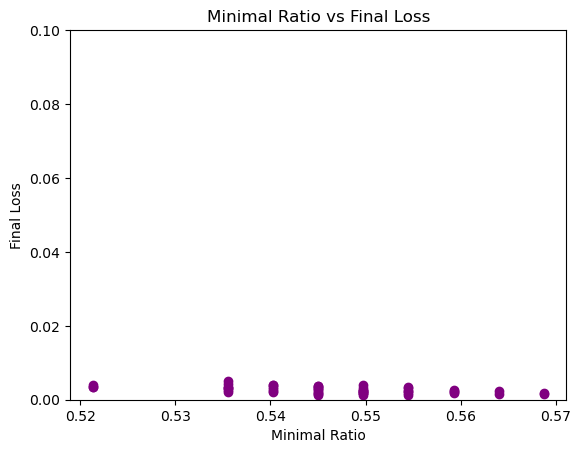

In [11]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn


def generate_data():
    x_vals = np.expand_dims(np.arange(-1.5, 1.5, 0.01), axis=1)
    y_vals = np.sinc(5 * x_vals)

    x_tensor = torch.tensor(x_vals, dtype=torch.float32)
    y_tensor = torch.tensor(y_vals, dtype=torch.float32)
    return x_tensor, y_tensor


class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.layer1 = nn.Linear(1, 6)
        self.layer2 = nn.Linear(6, 10)
        self.layer3 = nn.Linear(10, 8)
        self.layer4 = nn.Linear(8, 4)
        self.output_layer = nn.Linear(4, 1)

    def forward(self, x):
        x = nn.functional.elu(self.layer1(x))  
        x = nn.functional.elu(self.layer2(x))  
        x = nn.functional.elu(self.layer3(x))  
        x = nn.functional.elu(self.layer4(x))  
        return self.output_layer(x)


def train_small_network(model, x, y, epochs=1500, learning_rate=0.002, min_grad_threshold=0.0001):
    loss_history = []
    grad_history = []
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_func = torch.nn.MSELoss()


    for epoch in range(epochs):
        model_output = model(x)
        loss_value = loss_func(model_output, y)
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()

        loss_history.append(loss_value.item())

        grad_total = 0.0
        for param in model.parameters():
            if param.grad is not None:
                grad_total += (param.grad.cpu().data.numpy() ** 2).sum()
        grad_norm = np.sqrt(grad_total)
        grad_history.append(grad_norm)

        if grad_norm < min_grad_threshold:
            print(f"Converged at epoch {epoch}, gradient norm below threshold.")
            break

    return loss_history, grad_history

def calculate_minimal_ratio(model, loss_fn, x_tensor, y_tensor):
    total_params = sum(p.numel() for p in model.parameters())
    hessian_matrix = torch.zeros((total_params, total_params))

    loss = loss_fn(model(x_tensor), y_tensor)
    jacobian = torch.autograd.grad(loss, list(model.parameters()), create_graph=True)
    jacobian = torch.cat([param_grad.flatten() for param_grad in jacobian])

    for idx in range(total_params):
        grad_row = torch.autograd.grad(jacobian[idx], list(model.parameters()), retain_graph=True)
        hessian_matrix[idx] = torch.cat([grad_val.flatten() for grad_val in grad_row])

    eigenvalues = torch.linalg.eigvalsh(hessian_matrix, UPLO='U')
    positive_eigen_count = (eigenvalues > 0).sum().item()
    minimal_ratio = positive_eigen_count / len(eigenvalues)
    return minimal_ratio

def multiple_model_training(num_models, x_tensor, y_tensor):
    loss_results = []
    minimal_ratios = []

    for i in range(num_models):
        print(f"Currently training model {i+1}")
        model = SmallNet()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0008, weight_decay=1e-6)
        loss_func = torch.nn.MSELoss()

        loss_value, _ = train_small_network(model, x_tensor, y_tensor)
        minimal_ratio = calculate_minimal_ratio(model, loss_func, x_tensor, y_tensor)

        loss_results.append(loss_value[-1])
        minimal_ratios.append(minimal_ratio)

    return minimal_ratios, loss_results

def plot_minimal_ratio_vs_loss(minimal_ratios, loss_results):
    plt.scatter(minimal_ratios, loss_results, color="purple")
    plt.xlabel("Minimal Ratio")
    plt.ylabel("Final Loss")
    plt.title("Minimal Ratio vs Final Loss")  
    plt.ylim([0.0, 0.1]) 
    plt.show()

def main():
    x_tensor, y_tensor = generate_data()

    num_models = 50  
    minimal_ratios, loss_results = multiple_model_training(num_models, x_tensor, y_tensor)

    plot_minimal_ratio_vs_loss(minimal_ratios, loss_results)


if __name__ == "__main__":
    main()